# MAC0318 - Teoria de controle - Notebook 3

*Pré-requisitos*: 
- **Software**: Para rodar este notebook corretamente, você deve ter o Python na versão 3.9 ou mais recente e a biblioteca NumPy instalada. Antes de começar, assegure-se de que essas condições são satisfeitas.
- **Conhecimento**: Esta atividade assume familiaridade com o uso de notebooks Jupyter e a manipulação de matrizes usando a bilbioteca NumPy. Recomendamos seguir algum tutorial da internet antes de realizar essa atividade, se esse não for o seu caso. Assumimos que você compreendeu os tópicos abordados nos Notebooks anteriores.

<span style="color:blue">Se você está rodando o notebook em sala de aula, você deve ativar o ambiente `duckievillage` antes de abrir o jupyter notebook e escolher o kernel `duckievillage`, para que os requerimentos sejam satisfeitos.</red>

## Cinemática direta

<figure style='float:right'>
    <div style="text-align:center;">
        <img src="./img/robot_kinematics.png" width="350" alt="robot kinematics">
    </div>
</figure>

Vamos primeiro simular o deslocamento do robô a partir de sinais de controle $u=\begin{bmatrix} v_A & \omega \end{bmatrix}^t$ especificando a velocidade linear e angular do referencial do robô. A equação diferencial ordinária para a pose do robô $q = \begin{bmatrix} x & y & \theta \end{bmatrix}$ no referencial global é dada por:

$$
\dot{q}(t) 
= 
\begin{bmatrix}
 \dot{x}_A \\ \dot{y}_A \\ \dot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
\cos \theta & 0 \\ 
\sin \theta & 0 \\ 
0 & 1
\end{bmatrix}
\begin{bmatrix}
v_A \\ \omega
\end{bmatrix}
$$

Como o computador só permite simular em tempo discreto, vamos aproximar a equação acima usando o método de integração direto de Euler, que transforma uma equação diferencial em uma equação de diferenças:

$$
q(t+\Delta t) = q(t) + \Delta t \cdot \dot{q}(t + \Delta t) \, ,
$$

onde $\Delta t$ é o tempo decorrido desde a última atualização (em segundos).

In [1]:
# A função forward determina o estado do robô, dado por sua pose, a partir do estado atual e dos sinais de sua velocidade linear e angular instântaneas.

import numpy as np

def forward(x, v, w, dt):
    ''' Computa cinemática direta para intervalo de tempo dt e sinais de controle v e w '''
    # integração discreta
    dx = dt * np.array([v*np.cos(x[2]), v*np.sin(x[2]), w])
    x += dx

In [2]:
# Vamos usar a função forward para simular a evolução do estado do robô a partir
# de um estado inicial para 2 passos de tempo com sinais de controle variando

x = np.zeros(3) # estado inicial x(0) = [0,0,0]
print('x(0) =', x)
forward(x, 0.2, 0, 0.1) # move adiante com velocidade de 0.2m/s por 0.1s
print('x(1) =', x)
forward(x, 0., 10, 0.1) # gira a 10 rad/s no eixo por 0.1s
print('x(2) =', x)

x(0) = [0. 0. 0.]
x(1) = [0.02 0.   0.  ]
x(2) = [0.02 0.   1.  ]


## 💡 Exercício 1

<figure style='float:right'>
    <div style="text-align:center;">
        <img src="./img/referencial.png" width="200" alt="robot kinematics">
    </div>
</figure>

Podemos dizer que o sistema de cinemática direta que descreve a pose do robô $q(t)$ em função das velocidades $v(t)$ e $w(t)$ acima é BIBO-estável? Justifique sua resposta, apontando porque o estado descrito pelo sistema será limitado com entradas limitadas ou apontando um contra-exemplo. Você pode usar as simulações das função `forward` como aproximações da dinâmica verdadeira do sistema para justificar sua resposta.

### RESPOSTA

O sistema não é BIBO-estável (como também comentamos em aula), já que para uma entrada limitada v=1m/s, w=0rad/s, temos que $\dot{q}(t)=[\cos(\theta), \sin(\theta), 0]$.

A pose (saída) vai para $q=[x+\cos(\theta)\cdot t,\; y+\sin(\theta)\cdot t,\; \theta]$ que é ilimitada

## Simulação do robô diferencial

Vamos agora implementar alguns comportamentos simples usando o modelo de cinemática direta do robô diferencial projetado.
Para simplificar, criamos uma classe `DifferentialRobot` que implementa a equação `forward` e permite gerar algumas visualizações da trajetória percorrida.
O código abaixo, por exemplo, faz o robô percorrer um círculo completo com velocidade 0,1 m/s.

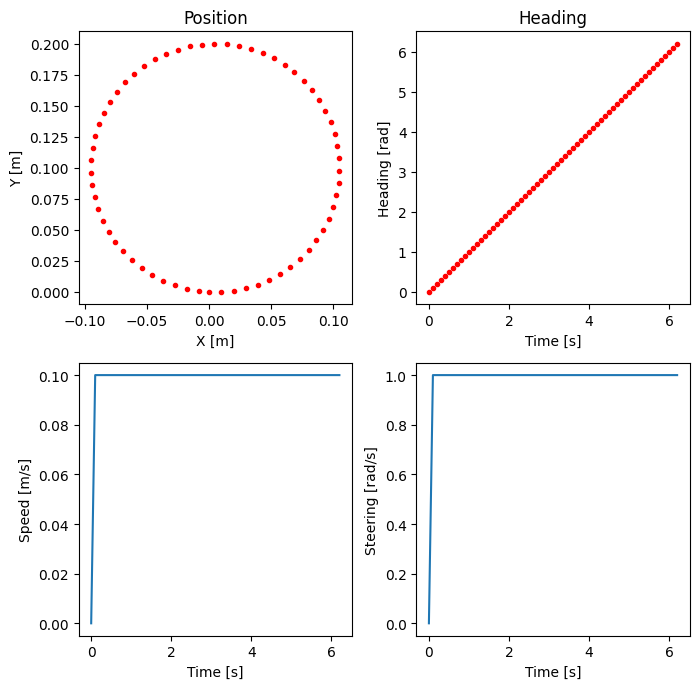

In [3]:
# Vamos usar uma biblioteca para exibir gráficos etc
from DifferentialDrive import DifferentialRobot 

robot_circle = DifferentialRobot() # dt = 0.1
# Dirija a uma velocidade constante com curvatura constante
for _ in range(62):
    robot_circle.forward(0.1, 1.0)
# exibe gráficos da trajetória
robot_circle.plot();

## 💡 Exercício 2

Modifique o comportamento do robô abaixo para que ele percorra um quadrado de lado 0,2 m como mostra a figura abaixo. 

<figure>
    <div style="text-align:center;">
        <img src="./img/square_output.png" width="300" alt="square robot trajectory">
    </div>
</figure>

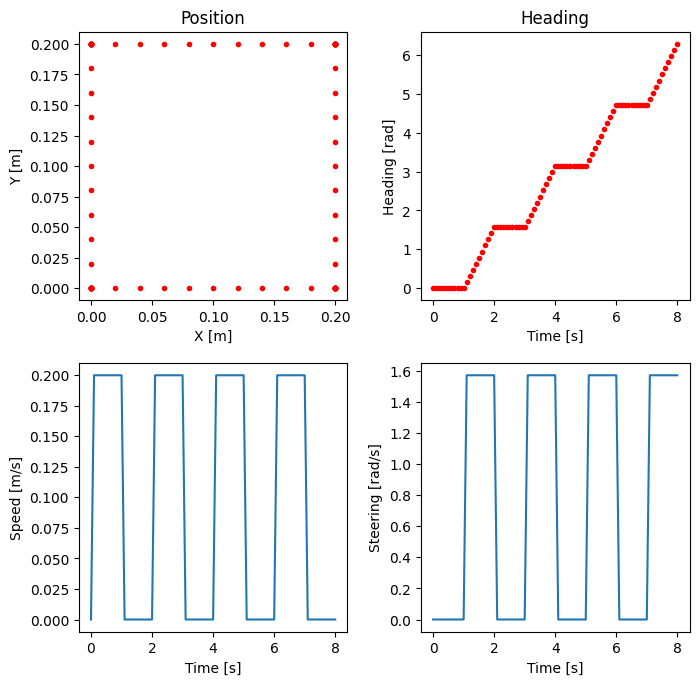

In [4]:
square_robot = DifferentialRobot()

#############################
# Coloque sua solução aqui! #
#############################
# O robô deve andar por 0,2m, depois virar 90 graus e repetir 3 vezes
def anda_para_frente(robot: DifferentialRobot):
    for _ in range(10):
        robot.forward(0.2, 0)

def vira_90_graus(robot: DifferentialRobot):
    for _ in range(10):
        robot.forward(0, np.pi/2)

for _ in range(4):
    anda_para_frente(square_robot)
    vira_90_graus(square_robot)

# exibe trajetória
square_robot.plot();

## Mudança de faixa

O comportamento abaixo simula uma mudança de faixa, de forma a mostrar uma lei controle mais complexo.

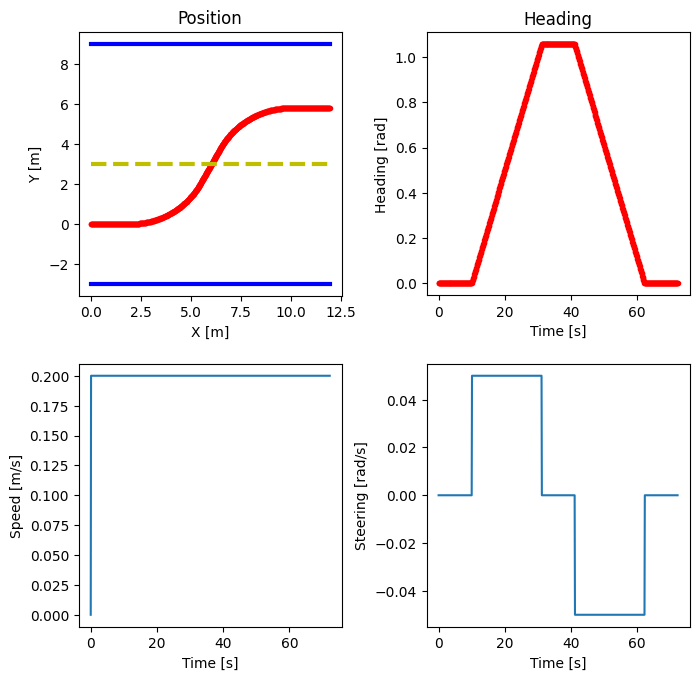

In [5]:
# Simula mudança de faixa de pista
lane_changer = DifferentialRobot()
v = 0.2 # manter velocidade constante
steer = 100*[0.0] + 211*[0.05] + 100*[0.0] + 211*[-0.05] + 100*[0.0] # sinal de controle de velocidade angular
#print(steer)
for w in steer:
    lane_changer.forward(v, w)
# exibe trajetória
fig, axes = lane_changer.plot();
# desenhe faixas
axes[0,0].plot([0.0, lane_changer.x[0]],[-3, -3], 'b', lw=3);
axes[0,0].plot([0.0, lane_changer.x[0]],[3, 3], 'y--', lw=3);
axes[0,0].plot([0.0, lane_changer.x[0]],[9, 9], 'b', lw=3);

## Mais sobre cinemática direta

Vamos agora implementar um simulador de trajetória de um robô diferencial 2D a partir de sinais de controle de velocidade angulares das rodas $u = \begin{bmatrix} \dot{\varphi}_l & \dot{\varphi}_r \end{bmatrix}^t$. A equação nesse caso é dada por:

$$
\begin{bmatrix}
 \dot{x}_A \\ \dot{y}_A \\ \dot{\theta}
\end{bmatrix}= 
\frac{R}{2}
\begin{bmatrix}
\cos \theta & 0 \\ 
\sin \theta & 0 \\ 
0 & 1
\end{bmatrix}
\begin{bmatrix}
1 & 1 \\ \frac{1}{L} & -\frac{1}{L}
\end{bmatrix}
\begin{bmatrix}
\dot{\varphi}_l \\ \dot{\varphi}_r
\end{bmatrix}
$$

Mais uma vez vamos adotar a aproximação por Euler:


$$
q(t+\Delta t) = q(t) + \Delta t \cdot \dot{q}(t + \Delta t) \, .
$$


In [6]:
def forward2(x, phi_l, phi_r, dt, LL, R):
    ''' Computa cinemática direta para intervalo de tempo dt e sinais de controle phi_l e phi_r.
    LL é a distância entre as rodas (2L), R é o raio das rodas e dt é o intervalo de tempo desde a 
    última atualização. '''
    # integração discreta
    v = R*(phi_l+phi_r)/2
    w = R*(phi_r-phi_l)/LL    
    forward(x, v, w, dt)

In [7]:
x = np.zeros(3) # estado inicial
print(x)
forward2(x, 10, 10, 0.1, 0.1, 0.0381) # move adiante com velocidade constante por 0.1s
print(x)
forward2(x, -10, 10, 0.1, 0.1, 0.0381) # gira a 10 rad/s no eixo por 0.1s
print(x)

[0. 0. 0.]
[0.0381 0.     0.    ]
[0.0381 0.     0.762 ]


Vamos novamente usar uma classe que implementa a função acima e nos permite visualizar as trajetórias

In [8]:
from DifferentialDrive import DifferentialRobot2

robot2 = DifferentialRobot2()
robot2.forward(10, 10) # move forward 
robot2.forward(-10, 10) # then rotate in place
robot2.x_hist

[array([0., 0., 0.]),
 array([0.0381, 0.    , 0.    ]),
 array([0.0381, 0.    , 0.762 ])]

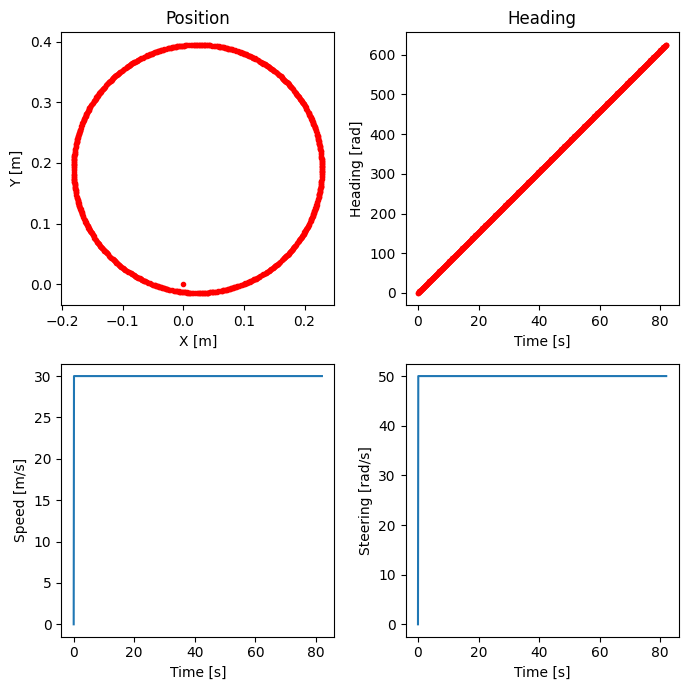

In [9]:
circle_robot2 = DifferentialRobot2()
for _ in range(820): 
    circle_robot2.forward(30, 50)
# plot trajectory
circle_robot2.plot();

## 💡 Exercício 3
<figure style='float:right'>
    <div style="text-align:center;">
        <img src="img/square_output.png" width="300" alt="square robot trajectory">
    </div>
</figure>

Implemente o controle do robô para que ele percorra o mesmo quadrado de lado 0,2 m do Exercício 2, controlando diretamente a a potência enviada a cada motor. 

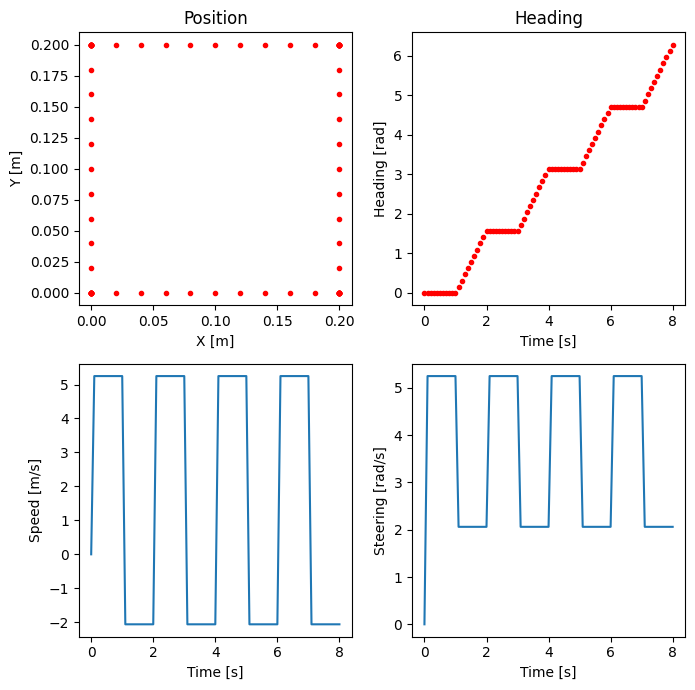

In [12]:
square_robot2 = DifferentialRobot2()

############
# TERMINAR #
############
def phi_from_v(robot: DifferentialRobot2, v: float):
    return v/robot.wheel_radius

def phi_from_w(robot: DifferentialRobot2, w: float):
    return (w*robot.wheel_base)/(robot.wheel_radius*2)

def anda_para_frente(robot: DifferentialRobot2, phi: float):
    for _ in range(10):
        robot.forward(phi, phi)

def vira_90_graus(robot: DifferentialRobot2, phi: float, lado: bool):
    phi1, phi2 = (phi, -phi) if lado else (-phi, phi)
    for _ in range(10):
        robot.forward(phi1, phi2)

for _ in range(4):
    phi = phi_from_v(square_robot2, 0.2)
    anda_para_frente(square_robot2, phi)
    phi = phi_from_w(square_robot2, np.pi/2)
    lado = False # controla se vira para a esquerda ou direita
    vira_90_graus(square_robot2, phi, lado)

# exibe trajetória
square_robot2.plot();